(1000, 50, 3)
Epoch 1/100, Loss: 15046.471435546875
Epoch 2/100, Loss: 14925.2509765625
Epoch 3/100, Loss: 15018.813232421875
Epoch 4/100, Loss: 14770.949523925781
Epoch 5/100, Loss: 14734.721923828125
Epoch 6/100, Loss: 14783.263671875
Epoch 7/100, Loss: 14584.235778808594
Epoch 8/100, Loss: 14386.8759765625
Epoch 9/100, Loss: 14198.920593261719
Epoch 10/100, Loss: 14032.222595214844
Epoch 11/100, Loss: 13879.039489746094
Epoch 12/100, Loss: 13607.506103515625
Epoch 13/100, Loss: 13300.390991210938
Epoch 14/100, Loss: 12958.778747558594
Epoch 15/100, Loss: 12824.387878417969
Epoch 16/100, Loss: 12542.470642089844
Epoch 17/100, Loss: 12242.193786621094
Epoch 18/100, Loss: 11948.801391601562
Epoch 19/100, Loss: 11699.674133300781
Epoch 20/100, Loss: 11323.747802734375
Epoch 21/100, Loss: 11122.874694824219
Epoch 22/100, Loss: 10904.916687011719
Epoch 23/100, Loss: 10584.99609375
Epoch 24/100, Loss: 10319.698303222656
Epoch 25/100, Loss: 10057.911010742188
Epoch 26/100, Loss: 9894.628051

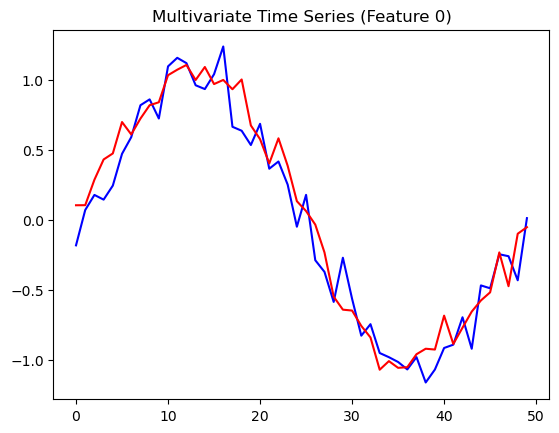

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# LSTM-based ScoreNet for Multivariate Time Series
class ScoreNetLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super(ScoreNetLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)  # Linear layer to predict the score for each feature

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), hidden_dim).to(x.device)  # Initial hidden state
        c_0 = torch.zeros(1, x.size(0), hidden_dim).to(x.device)  # Initial cell state
        
        lstm_out, _ = self.lstm(x, (h_0, c_0))  # LSTM output
        score_pred = self.fc(lstm_out)  # Linear layer to predict score at each time step
        return score_pred

# Denoising score matching loss function (unchanged)
def score_matching_loss(score_model, x_noisy, x_original, sigma):
    score_pred = score_model(x_noisy)  # Predict score
    score_true = -(x_noisy - x_original) / (sigma ** 2)  # True score from Gaussian perturbation
    loss = ((score_pred - score_true) ** 2).sum(dim=[1, 2]).mean()  # MSE loss on all time steps and features
    return loss

# Add Gaussian noise to multivariate time series
def add_noise(x, sigma):
    noise = torch.randn_like(x) * sigma
    x_noisy = x + noise
    return x_noisy

# Training loop for multivariate time series
def train_score_grad(score_model, data_loader, epochs, sigma, lr=1e-3):
    optimizer = torch.optim.Adam(score_model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        total_loss = 0
        for x_batch in data_loader:
            x_batch = x_batch.to(torch.float32)
            
            # Generate noisy data
            x_noisy = add_noise(x_batch, sigma)
            
            # Compute loss
            loss = score_matching_loss(score_model, x_noisy, x_batch, sigma)
            
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(data_loader)}")

# Generate synthetic multivariate time series data (e.g., sine waves with multiple features)
def generate_multivariate_sine_wave_data(n_samples=1000, seq_len=50, n_features=3, noise_level=0.1):
    t = np.linspace(0, 2 * np.pi, seq_len)
    data = np.stack([np.sin(t + i) for i in range(n_features)], axis=-1)  # Sine waves for each feature
    data = np.repeat(data[np.newaxis,:,:], n_samples, axis=0)
    print(data.shape)
    data += noise_level * np.random.randn(n_samples, seq_len, n_features)  # Add Gaussian noise
    return torch.tensor(data, dtype=torch.float32)

# Plot multivariate time series
def plot_multivariate_time_series(true_data,generated_data, feature_idx=0, title="Multivariate Time Series"):
    true_data_tmp = true_data.detach().cpu().numpy()
    generated_data_tmp = generated_data.detach().cpu().numpy()
    plt.plot(generated_data_tmp[0, :, feature_idx], color='blue',label="Generated data")
    plt.plot(true_data_tmp[0, :, feature_idx], color='red',label="True data")
    plt.title(f"{title} (Feature {feature_idx})")
    plt.show()

# Sampling from the learned score model using Langevin Dynamics (for multivariate)
def generate_samples(score_model, seq_len, num_features, num_samples, sigma, num_steps=500, step_size=0.01):
    """
    Generate new multivariate time series samples using the trained ScoreGrad model via Langevin dynamics.
    
    Args:
        score_model: Trained score network (LSTM-based).
        seq_len: Length of the time series sequence.
        num_features: Number of features per time step.
        num_samples: Number of time series samples to generate.
        sigma: Noise scale used during training.
        num_steps: Number of Langevin steps (iterations).
        step_size: Size of each step in Langevin dynamics.

    Returns:
        Generated time series samples (Tensor of shape [num_samples, seq_len, num_features]).
    """
    # Start with Gaussian noise as initial samples
    x = torch.randn(num_samples, seq_len, num_features)  # Initial noisy time series (random noise)
    
    # Perform iterative Langevin updates
    for step in range(num_steps):
        # Compute the score (gradient of log density) at each step
        with torch.no_grad():
            score = score_model(x)
        
        # Update samples by taking a gradient step
        noise = torch.randn_like(x) * np.sqrt(step_size)  # Small Gaussian noise
        x = x + step_size * score + noise  # Langevin update with added noise
        
        if step % 100 == 0:
            print(f"Langevin step {step}/{num_steps}")
    
    return x

# Main function to train on multivariate time series data
if __name__ == "__main__":
    # Hyperparameters
    batch_size = 64
    epochs = 100
    sigma = 0.1  # Noise scale
    lr = 1e-3
    seq_len = 50  # Sequence length
    hidden_dim = 128  # Hidden dimension of LSTM
    num_features = 3  # Number of features in multivariate time series
    num_samples = 10  # Number of time series samples to generate
    num_steps = 500  # Number of Langevin steps
    step_size = 0.01  # Langevin step size

    # Generate synthetic multivariate sine wave data
    time_series_data = generate_multivariate_sine_wave_data(n_samples=1000, seq_len=seq_len, n_features=num_features, noise_level=0.1)
    data_loader = torch.utils.data.DataLoader(time_series_data, batch_size=batch_size, shuffle=True)
    
    # Initialize LSTM-based score model for multivariate time series
    score_model = ScoreNetLSTM(input_dim=num_features, hidden_dim=hidden_dim)
    
    # Train ScoreGrad model on multivariate time series data
    train_score_grad(score_model, data_loader, epochs, sigma, lr)
    
    # Generate new time series samples
    generated_samples = generate_samples(score_model, seq_len, num_features, num_samples, sigma, num_steps, step_size)
    
    # Plot the first feature of the generated time series
    # plot_multivariate_time_series(time_series_data, feature_idx=0, title="Time series")
    plot_multivariate_time_series(time_series_data,generated_samples, feature_idx=0)


(1000, 50, 3)
Epoch 1/100, Loss: 5969.301788330078
Epoch 2/100, Loss: 6065.144012451172
Epoch 3/100, Loss: 5954.1605224609375
Epoch 4/100, Loss: 5929.747222900391
Epoch 5/100, Loss: 5913.2218017578125
Epoch 6/100, Loss: 5935.284332275391
Epoch 7/100, Loss: 5812.2440185546875
Epoch 8/100, Loss: 5822.756500244141
Epoch 9/100, Loss: 5748.129486083984
Epoch 10/100, Loss: 5627.051605224609
Epoch 11/100, Loss: 5571.691986083984
Epoch 12/100, Loss: 5529.542999267578
Epoch 13/100, Loss: 5392.958923339844
Epoch 14/100, Loss: 5359.282897949219
Epoch 15/100, Loss: 5267.939178466797
Epoch 16/100, Loss: 5109.6873779296875
Epoch 17/100, Loss: 4973.237243652344
Epoch 18/100, Loss: 4867.7080078125
Epoch 19/100, Loss: 4786.552734375
Epoch 20/100, Loss: 4660.847686767578
Epoch 21/100, Loss: 4560.2437744140625
Epoch 22/100, Loss: 4478.965423583984
Epoch 23/100, Loss: 4303.031311035156
Epoch 24/100, Loss: 4267.716339111328
Epoch 25/100, Loss: 4164.960906982422
Epoch 26/100, Loss: 4059.4784393310547
Epoch 

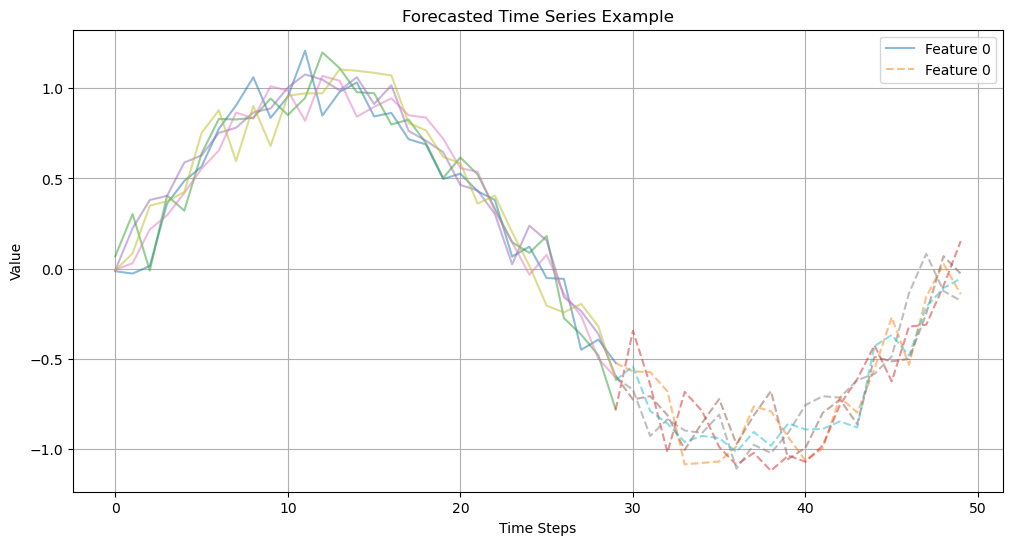

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Modified LSTM-based ScoreNet for conditional ScoreGrad forecasting
class ScoreNetLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super(ScoreNetLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)  # Linear layer to predict the score for each feature

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), hidden_dim).to(x.device)  # Initial hidden state
        c_0 = torch.zeros(1, x.size(0), hidden_dim).to(x.device)  # Initial cell state
        lstm_out, _ = self.lstm(x, (h_0, c_0))  # LSTM output
        score_pred = self.fc(lstm_out)  # Linear layer to predict score at each time step
        return score_pred

# Define the loss function for conditional score matching
def conditional_score_matching_loss(score_model, x_past, x_future_noisy, x_future, sigma):
    # Combine past and future as input for score prediction
    x_combined = torch.cat((x_past, x_future_noisy), dim=1)
    score_pred = score_model(x_combined)
    
    # Calculate true score only on future sequence (target for forecasting)
    score_true = -(x_future_noisy - x_future) / (sigma ** 2)
    loss = ((score_pred[:, -x_future.shape[1]:] - score_true) ** 2).sum(dim=[1, 2]).mean()  # MSE on future
    return loss

# Generate noisy data (only for future sequence)
def add_noise(x, sigma):
    noise = torch.randn_like(x) * sigma
    return x + noise

# Training loop for conditional ScoreGrad forecasting
def train_score_grad_forecasting(score_model, data_loader, seq_len_past, seq_len_future, epochs, sigma, lr=1e-3):
    optimizer = torch.optim.Adam(score_model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        total_loss = 0
        for x_batch in data_loader:
            x_past = x_batch[:, :seq_len_past].to(torch.float32)
            x_future = x_batch[:, seq_len_past:].to(torch.float32)
            
            # Generate noisy future data
            x_future_noisy = add_noise(x_future, sigma)
            
            # Compute loss
            loss = conditional_score_matching_loss(score_model, x_past, x_future_noisy, x_future, sigma)
            
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(data_loader)}")

# Forecast generation using Langevin Dynamics for conditional sampling
def generate_forecast(score_model, x_past, seq_len_future, num_features, sigma, num_steps=500, step_size=0.01):
    """
    Generate forecasts by conditioning on x_past and iteratively denoising the future.
    
    Args:
        score_model: Trained score network.
        x_past: Past time series segment for conditioning (Tensor of shape [batch_size, seq_len_past, num_features]).
        seq_len_future: Length of the future sequence to forecast.
        num_features: Number of features per time step.
        sigma: Noise scale used during training.
        num_steps: Number of Langevin steps (iterations).
        step_size: Size of each step in Langevin dynamics.

    Returns:
        Forecasted future sequence (Tensor of shape [batch_size, seq_len_future, num_features]).
    """
    # Initialize future sequence with noise
    x_future = torch.randn(x_past.size(0), seq_len_future, num_features).to(x_past.device)
    
    # Iterative Langevin updates for conditional generation
    for step in range(num_steps):
        # Combine past and current future prediction
        x_combined = torch.cat((x_past, x_future), dim=1)
        
        # Predict score for future
        with torch.no_grad():
            score = score_model(x_combined)[:, -seq_len_future:]  # Only take score for future part
        
        # Update future sequence with Langevin dynamics
        noise = torch.randn_like(x_future) * np.sqrt(step_size)
        x_future = x_future + step_size * score + noise  # Langevin update with added noise
        
        if step % 100 == 0:
            print(f"Langevin step {step}/{num_steps}")
    
    return x_future

def plot_multivariate_time_series(data_past,data_forecast, title="Multivariate Time Series", feature_indices=None, show=True):
    """
    Plot multivariate time series data.
    
    Args:
        data: Tensor of shape [num_samples, seq_len, num_features] containing time series data.
        title: Title for the plot.
        feature_indices: List of feature indices to plot. If None, all features will be plotted.
        show: If True, show the plot.
    """
    # data = data.detach().cpu().numpy()  # Convert to NumPy for plotting
    num_samples, seq_len_past, num_features = data_past.shape
    num_samples, seq_len_forecast, num_features = data_forecast.shape
    
    if feature_indices is None:
        feature_indices = range(num_features)  # Plot all features if none specified

    # Create a figure for the specified features
    plt.figure(figsize=(12, 6))

    arr_tmp = torch.cat((data_past, data_forecast), dim=1).detach().numpy()
    
    for feature_idx in feature_indices:
        # Plot each feature for all samples
        for i in range(num_samples):
            # plt.plot(arr_tmp[i, :, feature_idx], label=f'Feature {feature_idx}' if i == 0 else "", alpha=0.5)
            plt.plot(arr_tmp[i, :seq_len_past, feature_idx], label=f'Feature {feature_idx}' if i == 0 else "", alpha=0.5)
            plt.plot(range(seq_len_past-1,seq_len_past+seq_len_forecast),arr_tmp[i, seq_len_past-1:, feature_idx], label=f'Feature {feature_idx}' if i == 0 else "", alpha=0.5,linestyle='dashed')

    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    
    if show:
        plt.show()

# Main function to train on time series data and generate forecasts
if __name__ == "__main__":
    # Hyperparameters
    batch_size = 64
    epochs = 100
    sigma = 0.1  # Noise scale
    lr = 1e-3
    seq_len_past = 30  # Length of conditioning (past) sequence
    seq_len_future = 20  # Length of forecasting (future) sequence
    hidden_dim = 128
    num_features = 3
    num_samples = 5  # Number of time series samples to forecast
    num_steps = 500  # Number of Langevin steps
    step_size = 0.01

    # Generate synthetic data (example multivariate sine wave)
    time_series_data = generate_multivariate_sine_wave_data(n_samples=1000, seq_len=seq_len_past + seq_len_future, n_features=num_features, noise_level=0.1)
    data_loader = torch.utils.data.DataLoader(time_series_data, batch_size=batch_size, shuffle=True)
    
    # Initialize and train ScoreNet for conditional forecasting
    score_model = ScoreNetLSTM(input_dim=num_features, hidden_dim=hidden_dim)
    train_score_grad_forecasting(score_model, data_loader, seq_len_past, seq_len_future, epochs, sigma, lr)
    
    # Forecast generation
    x_past = time_series_data[:num_samples, :seq_len_past]
    forecasted_future = generate_forecast(score_model, x_past, seq_len_future, num_features, sigma, num_steps, step_size)
    
    # Plot the forecast for the first feature of the first sample
    plot_multivariate_time_series(x_past, forecasted_future, feature_indices=[0], title="Forecasted Time Series Example")


# Use ScoreGrad for COPE 

In [3]:
import pickle
import os 
import netCDF4 as netcdf
import skimage

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))


# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

time_period = 120
grid_lat_size = lat.shape[0]
grid_lon_size = lon.shape[0]

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 0:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))
            lat_size = dic_reduced_ssp585[m][i][0,:,:].shape[0]
            lon_size = dic_reduced_ssp585[m][i][0,:,:].shape[1]

######## Store Nan indices 

nan_idx = []
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    for idx_i,i in enumerate(dic_reduced_ssp585[m].keys()):    

        nan_idx_tmp = list(np.where(np.isnan(dic_reduced_ssp585[m][i][0,:,:].ravel())==True)[0])        
        nan_idx = list(set(nan_idx) | set(nan_idx_tmp))

notnan_idx = list(set(list(range(lon_size*lat_size))) - set(nan_idx))

############################


# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    y_tmp = np.zeros((len(dic_reduced_ssp585[m].keys()),time_period, lat_size*lon_size))
    
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        y_tmp[idx_i,:,:] = dic_reduced_ssp585[m][i][131:,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[idx_i,:,nan_idx] = float('nan')
           
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())
        else:
            mean_ref_ensemble += np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())

    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = y_tmp[idx_i,:,:] - mean_ref_ensemble


# compute the forced response
dic_forced_response_ssp585 = {}
dic_forced_response_ssp585_tmp = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()
    dic_forced_response_ssp585_tmp[m] = dic_reduced_ssp585[m].copy()

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_tmp = dic_reduced_ssp585[m][i][131:,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')

        if idx_i == 0:
            mean_spatial_ensemble = y_tmp/ len(dic_forced_response_ssp585[m].keys())
        else:
            mean_spatial_ensemble += y_tmp/ len(dic_forced_response_ssp585[m].keys())

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble)
    # dic_forced_response_ssp585_tmp[m] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble)

y_forced_response = {}
x_predictor = {}
count_x = 0


for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = np.zeros((len(dic_processed_ssp585[m].keys()),time_period,lat_size*lon_size))
    x_predictor[m] = np.zeros((len(dic_processed_ssp585[m].keys()),time_period,lat_size*lon_size))

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):


        y_forced_response[m][idx_i,:,:] = dic_forced_response_ssp585[m][i]
        x_predictor[m][idx_i,:,:] = dic_processed_ssp585[m][i]

    
        x_predictor[m][idx_i,:,nan_idx] = float('nan')
        y_forced_response[m][idx_i,:,nan_idx] = float('nan')

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


/tmp/ipykernel_3336/3846238430.py:93: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())
/tmp/ipykernel_3336/3846238430.py:95: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())


In [4]:
# Data preprocessing
x_train = 0
y_train = 0

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    if idx_m == 0:
        x_train = torch.nan_to_num(torch.from_numpy(x_predictor[m])).to(torch.float64)
        y_train = torch.nan_to_num(torch.from_numpy(y_forced_response[m])).to(torch.float64)
    else:
        x_train = torch.cat([x_train, torch.nan_to_num(torch.from_numpy(x_predictor[m])).to(torch.float64)],axis=0)
        y_train = torch.cat([y_train, torch.nan_to_num(torch.from_numpy(y_forced_response[m])).to(torch.float64)],axis=0)

In [5]:
# data_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True)

In [6]:
#  # Hyperparameters
# batch_size = 64
# epochs = 100
# sigma = 0.1  # Noise scale
# lr = 1e-1
# seq_len = 33  # Sequence length
# hidden_dim = 128  # Hidden dimension of LSTM
# num_features = lat_size*lon_size  # Number of features in multivariate time series
# num_steps = 500  # Number of Langevin steps
# step_size = 0.01  # Langevin step size

# # Initialize LSTM-based score model for multivariate time series
# score_model = ScoreNetLSTM(input_dim=lat_size*lon_size, hidden_dim=hidden_dim)
    
# # Train ScoreGrad model on multivariate time series data
# train_score_grad(score_model, data_loader, epochs, sigma, lr)
    
# # Generate new time series samples

# generated_samples = generate_samples(score_model, seq_len, num_features, num_samples, sigma, num_steps, step_size)
    
# # Plot the first feature of the generated time series
# # plot_multivariate_time_series(time_series_data, feature_idx=0, title="Time series")
# plot_multivariate_time_series(y_train[:,:,:],generated_samples, feature_idx=50)

In [ ]:
# Hyperparameters
batch_size = 64
epochs = 1000
sigma = 0.1  # Noise scale
lr = 1e-3
seq_len_past = 80  # Length of conditioning (past) sequence
seq_len_future = 40  # Length of forecasting (future) sequence
hidden_dim = 128
num_features = lon_size*lat_size
num_samples = 5  # Number of time series samples to forecast
num_steps = 500  # Number of Langevin steps
step_size = 0.01

# Generate synthetic data (example multivariate sine wave)
# time_series_data = generate_multivariate_sine_wave_data(n_samples=1000, seq_len=seq_len_past + seq_len_future, n_features=num_features, noise_level=0.1)

data_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True)
    
# Initialize and train ScoreNet for conditional forecasting
score_model = ScoreNetLSTM(input_dim=num_features, hidden_dim=hidden_dim)
train_score_grad_forecasting(score_model, data_loader, seq_len_past, seq_len_future, epochs, sigma, lr)
    
# Forecast generation
x_past = x_train[:num_samples, :seq_len_past]
print(x_past.shape)
forecasted_future = generate_forecast(score_model, x_past, seq_len_future, num_features, sigma, num_steps, step_size)

# Plot the forecast for the first feature of the first sample
plot_multivariate_time_series(x_past, forecasted_future, feature_indices=[0], title="Forecasted Time Series Example")

Epoch 1/1000, Loss: 10371027.666666666
Epoch 2/1000, Loss: 10365923.0
Epoch 3/1000, Loss: 10366616.333333334
Epoch 4/1000, Loss: 10372130.833333334
Epoch 5/1000, Loss: 10364454.833333334
Epoch 6/1000, Loss: 10368534.833333334
Epoch 7/1000, Loss: 10365004.833333334
Epoch 8/1000, Loss: 10368240.166666666
Epoch 9/1000, Loss: 10365095.0
Epoch 10/1000, Loss: 10371409.166666666
Epoch 11/1000, Loss: 10368173.833333334
Epoch 12/1000, Loss: 10374054.333333334
Epoch 13/1000, Loss: 10375273.0
Epoch 14/1000, Loss: 10370542.333333334
Epoch 15/1000, Loss: 10371026.166666666
Epoch 16/1000, Loss: 10368409.833333334
Epoch 17/1000, Loss: 10367995.5
Epoch 18/1000, Loss: 10371283.333333334
Epoch 19/1000, Loss: 10368405.666666666
Epoch 20/1000, Loss: 10372033.5
Epoch 21/1000, Loss: 10370613.5
Epoch 22/1000, Loss: 10360514.5
Epoch 23/1000, Loss: 10374266.166666666
Epoch 24/1000, Loss: 10362689.833333334
Epoch 25/1000, Loss: 10365738.833333334
Epoch 26/1000, Loss: 10364261.833333334
Epoch 27/1000, Loss: 1036